## Overfitting Exploration

### Useful Preliminaries

In [20]:
import os
import sys
sys.path.append("..")  # add project root

import shutil
import re
from argparse import ArgumentParser
from pickle import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import zarr
import dask.array as da

from ray import tune

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

from src.data_utils import *
from src.constants import *
from src.tuner import train_cv, RayAdaptiveRepeatedCVSearch

In [21]:
pd.options.display.float_format = '{:10,.3f}'.format

In [22]:
np.random.seed(420)

In [23]:
sns.set_theme(context="talk")

In [24]:
# path constants
train_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/"

In [25]:
# check img directory exists, if not make it
img_dir = "/home/mr2238/project_pi_np442/mr2238/accelerate/imgs/overfit"
os.makedirs(img_dir, exist_ok=True)

### Loading Model and Results

In [ ]:
dataset_name = "smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp"
run_name = "current"
small = False
model_name = f"models{'_debug' if small else ''}_{run_name}"

In [ ]:
model_store = os.path.join(train_dir, dataset_name, model_name)
print(model_store)

In [ ]:
print(os.listdir(model_store))

In [ ]:
model_states = {}
for f in os.listdir(model_store):
    if not f.endswith(".pkl"):
        state = tune.ExperimentAnalysis(experiment_checkpoint_path=os.path.join(model_store, f))
        model_states[f] = state

In [ ]:
# TBD load test metrics? could also just move this to eval.py

### Plot Best Results

In [ ]:
for k, v in model_states.items():
    print(k)
    print(v.results_df.columns[:9])

In [ ]:
# gather results
def gather_results(model_states, metric, others_to_fetch):
    rows = []
    of_interest = ['model'] + [metric] + others_to_fetch
    for k, v in model_states.items():
        df = v.results_df
        try:
            result = df.loc[[df[metric].idxmax()]]
            result["model"] = k
            rows.append(result[of_interest])
        except:
            continue
    return pd.concat(rows, ignore_index=True)

In [ ]:
others = ['mean_train_auc', 'std_val_auc', 'std_train_auc',
       'mean_val_auc', 'mean_val_balanced_accuracy',
       'std_val_balanced_accuracy', 'std_train_balanced_accuracy']

In [ ]:
r = gather_results(model_states, 'mean_train_balanced_accuracy', others)
print(r)

### Plot results per model

##### Prelims

In [26]:
run_name = "current"

In [27]:
# list training dirs
dataset_names = os.listdir(train_dir)
run_name = "current"
dataset_names

['debug',
 'downsample_w_300s_hr_rso2r_rso2l_spo2_abp',
 'downsample_w_60s_rso2r_rso2l_abp',
 'robust_downsample_w_300s_hr_rso2r_rso2l_spo2_abp',
 'robust_downsample_w_60s_rso2r_rso2l_abp',
 'robust_smooth_downsample_w_1200s_rso2r_rso2l_abp',
 'robust_smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp',
 'robust_smooth_w_300s_hr_rso2r_rso2l_spo2_abp',
 'robust_w_300s_hr_rso2r_rso2l_spo2_abp',
 'robust_w_60s_rso2r_rso2l_abp',
 'smooth_downsample_w_1200s_rso2r_rso2l_abp',
 'smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp',
 'smooth_w_300s_hr_rso2r_rso2l_spo2_abp',
 'var80_downsample_w_60s_rso2r_rso2l_abp',
 'var80_smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp',
 'w_300s_hr_rso2r_rso2l_spo2_abp',
 'w_60s_rso2r_rso2l_abp']

In [28]:
dataset_names.remove("debug")

In [29]:
# loop through training dirs, pick out training results per model
def model_path_iter(dataset_names, run_name):
    for ds in dataset_names:
        ds_path = os.path.join(train_dir, ds)
        for model_dir in os.listdir(ds_path):
            if run_name in model_dir:
                # grab model paths
                md_path = os.path.join(ds_path, model_dir)
                for m in os.listdir(md_path):
                    model_path = os.path.join(md_path, m)
                    if not m.endswith(".pkl"):
                        yield model_path, "debug" in model_dir

In [30]:
of_interest = ['mean_val_auc', 'mean_train_auc', 'std_val_auc', 'std_train_auc',
       'mean_train_balanced_accuracy', 'mean_val_balanced_accuracy',
       'std_val_balanced_accuracy', 'std_train_balanced_accuracy']

##### DF

In [31]:
large_results = []
for m, d in model_path_iter(dataset_names, run_name):
    # grab results_df
    try:
        state = tune.ExperimentAnalysis(experiment_checkpoint_path=m)
    except ValueError:
        print(f"Could not find experiment at {m}, skipping.")
        continue
    df = state.results_df
    if df.shape[1] > 0:
        df = df[df['done'] == True]
        df = df[of_interest]
    
        # add debug flag to df
        df['debug'] = d
        # add model_name
        df['model'] = os.path.basename(m)

        # add dataset_name
        df['dataset'] = os.path.basename(os.path.dirname(os.path.dirname(m)))

        # combine into one dataset
        large_results.append(df)

large_result_df = pd.concat(large_results)
print(large_result_df.shape)

2025-12-27 09:17:41,774	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_cv_702813fa: FileNotFoundError('Could not fetch metrics for train_cv_702813fa: both result.json and progress.csv were not found at /home/mr2238/project_pi_np442/mr2238/accelerate/data/training/robust_downsample_w_60s_rso2r_rso2l_abp/models_current/rocket_raw/train_cv_702813fa_17_class_weight=None,estimator__alpha=0.0011,max_dilations_per_kernel=32,n_features_per_kernel=12,n_kernels=1500_2025-12-23_04-03-04')


Could not find experiment at /home/mr2238/project_pi_np442/mr2238/accelerate/data/training/robust_smooth_downsample_w_1200s_rso2r_rso2l_abp/models_current/knn_multivar_raw, skipping.
Could not find experiment at /home/mr2238/project_pi_np442/mr2238/accelerate/data/training/robust_smooth_downsample_w_1200s_rso2r_rso2l_abp/models_debug_current/rocket_raw, skipping.
Could not find experiment at /home/mr2238/project_pi_np442/mr2238/accelerate/data/training/robust_smooth_downsample_w_1200s_rso2r_rso2l_abp/models_debug_current/svm_raw, skipping.
(5217, 11)


In [32]:
mapping = {"_separate_decomp": "separate_pca", "_pca": "pca", "_raw": "raw"}
modelnames = [
            "log_reg",
            "svm",
            "knn",
            "rand_forest",
            "decision_tree",
            "xgb",
            "rocket",
            "kn_multivar",
        ]

In [33]:
large_result_df["model"] = large_result_df["model"].str.replace("_separate_pca", "_separate_decomp")
large_result_df["model"] = large_result_df["model"].str.replace("knn_multivar", "kn_multivar")
large_result_df["datamode"] = large_result_df["model"].apply(
    lambda x: next(
        (v for k, v in mapping.items() if k in x),
        None  # default if no match
    )
)
large_result_df["datamode"]
large_result_df["model"] = large_result_df["model"].apply(
    lambda x: next(
        (m for m in modelnames if m in x),
        None  # default if no match
    )
)
large_result_df["model"]

trial_id
50ae03e9    decision_tree
709e6fa8    decision_tree
003137f2    decision_tree
8351693c    decision_tree
35adc69a    decision_tree
                ...      
a852f8a8              svm
a44ed807              svm
d99348e2              svm
7bceaf1a              svm
9a849252              svm
Name: model, Length: 5217, dtype: object

In [34]:
long_df = large_result_df.melt(
    id_vars=["dataset", "debug", "model", "datamode"],
    value_vars=["mean_train_auc", "mean_val_auc"],
    var_name="metric",
    value_name="auc"
)

<Figure size 1000x500 with 0 Axes>

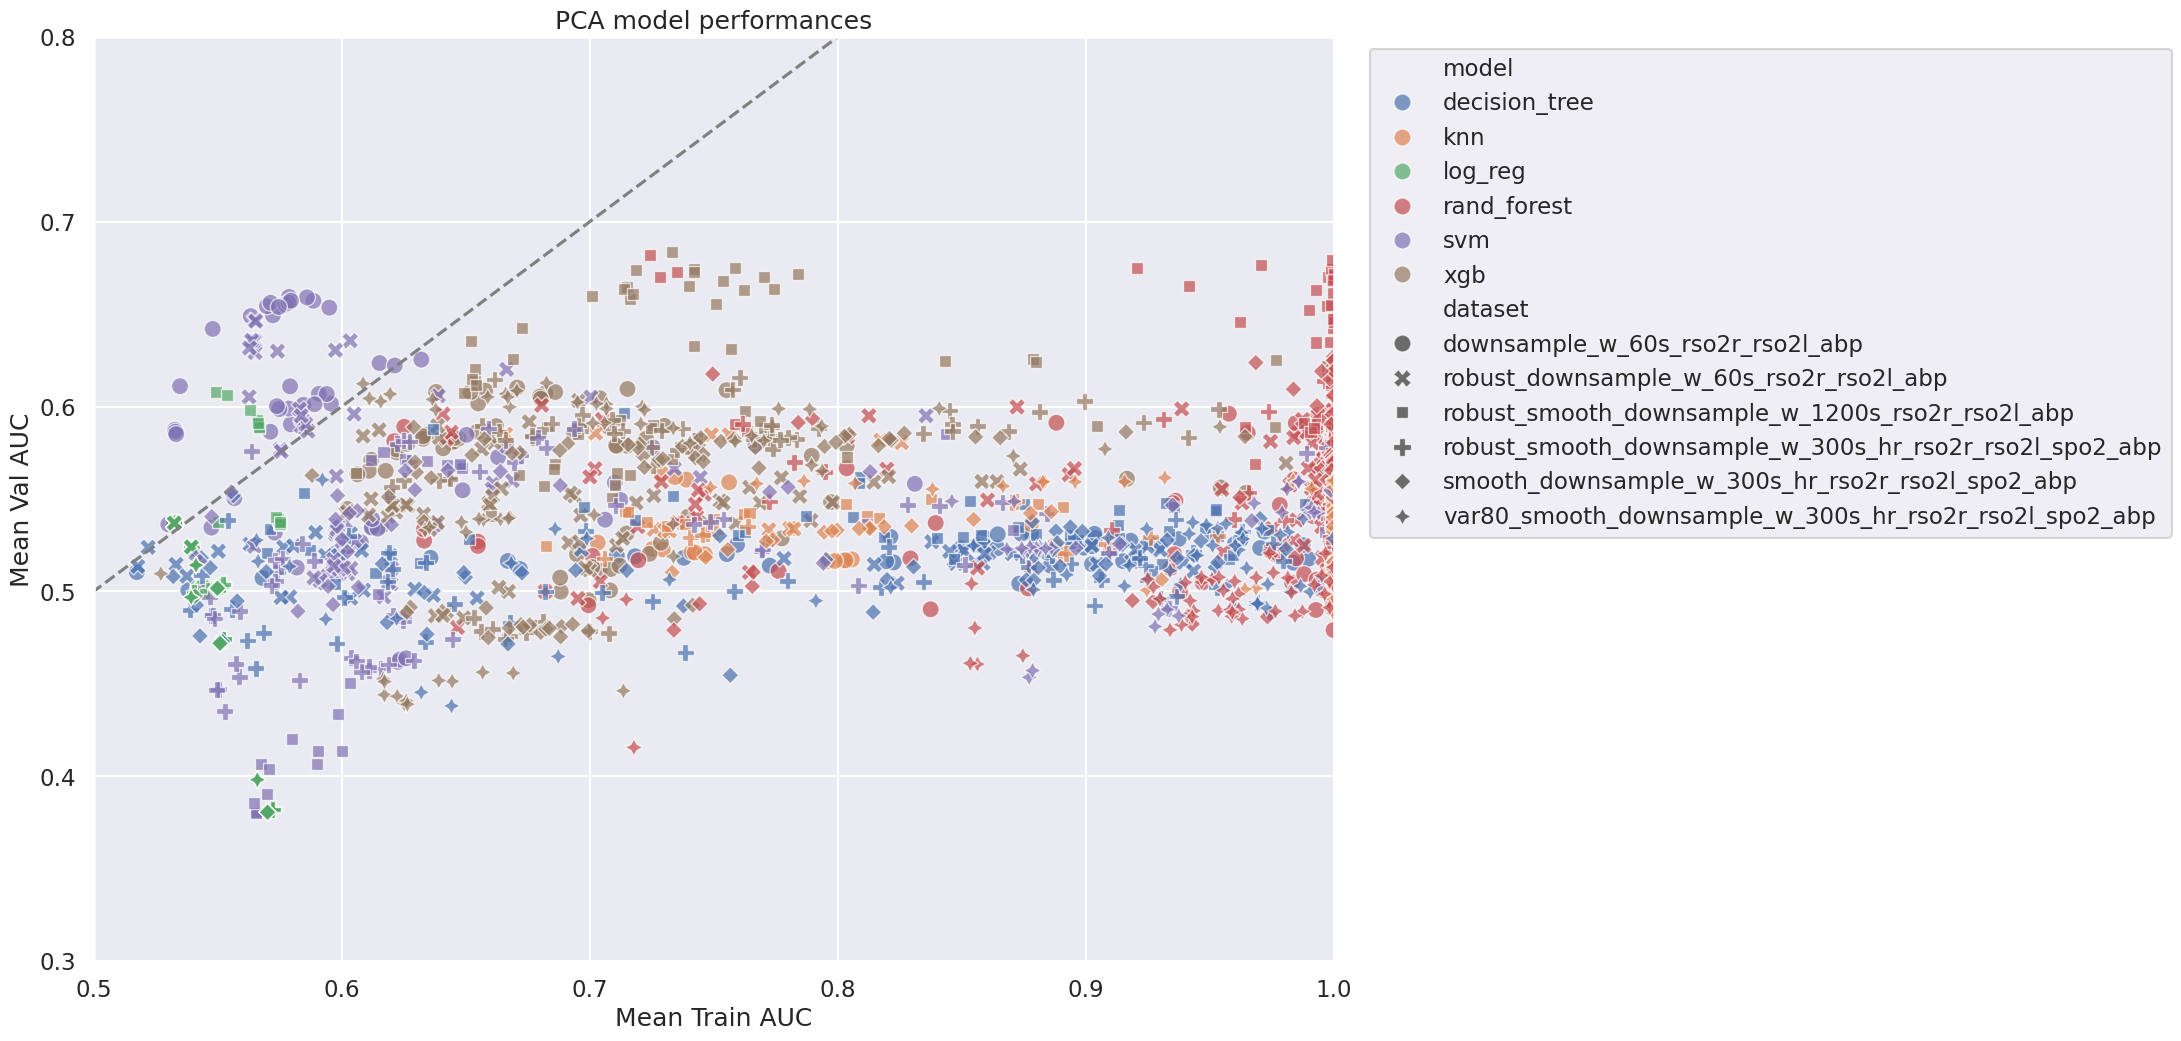

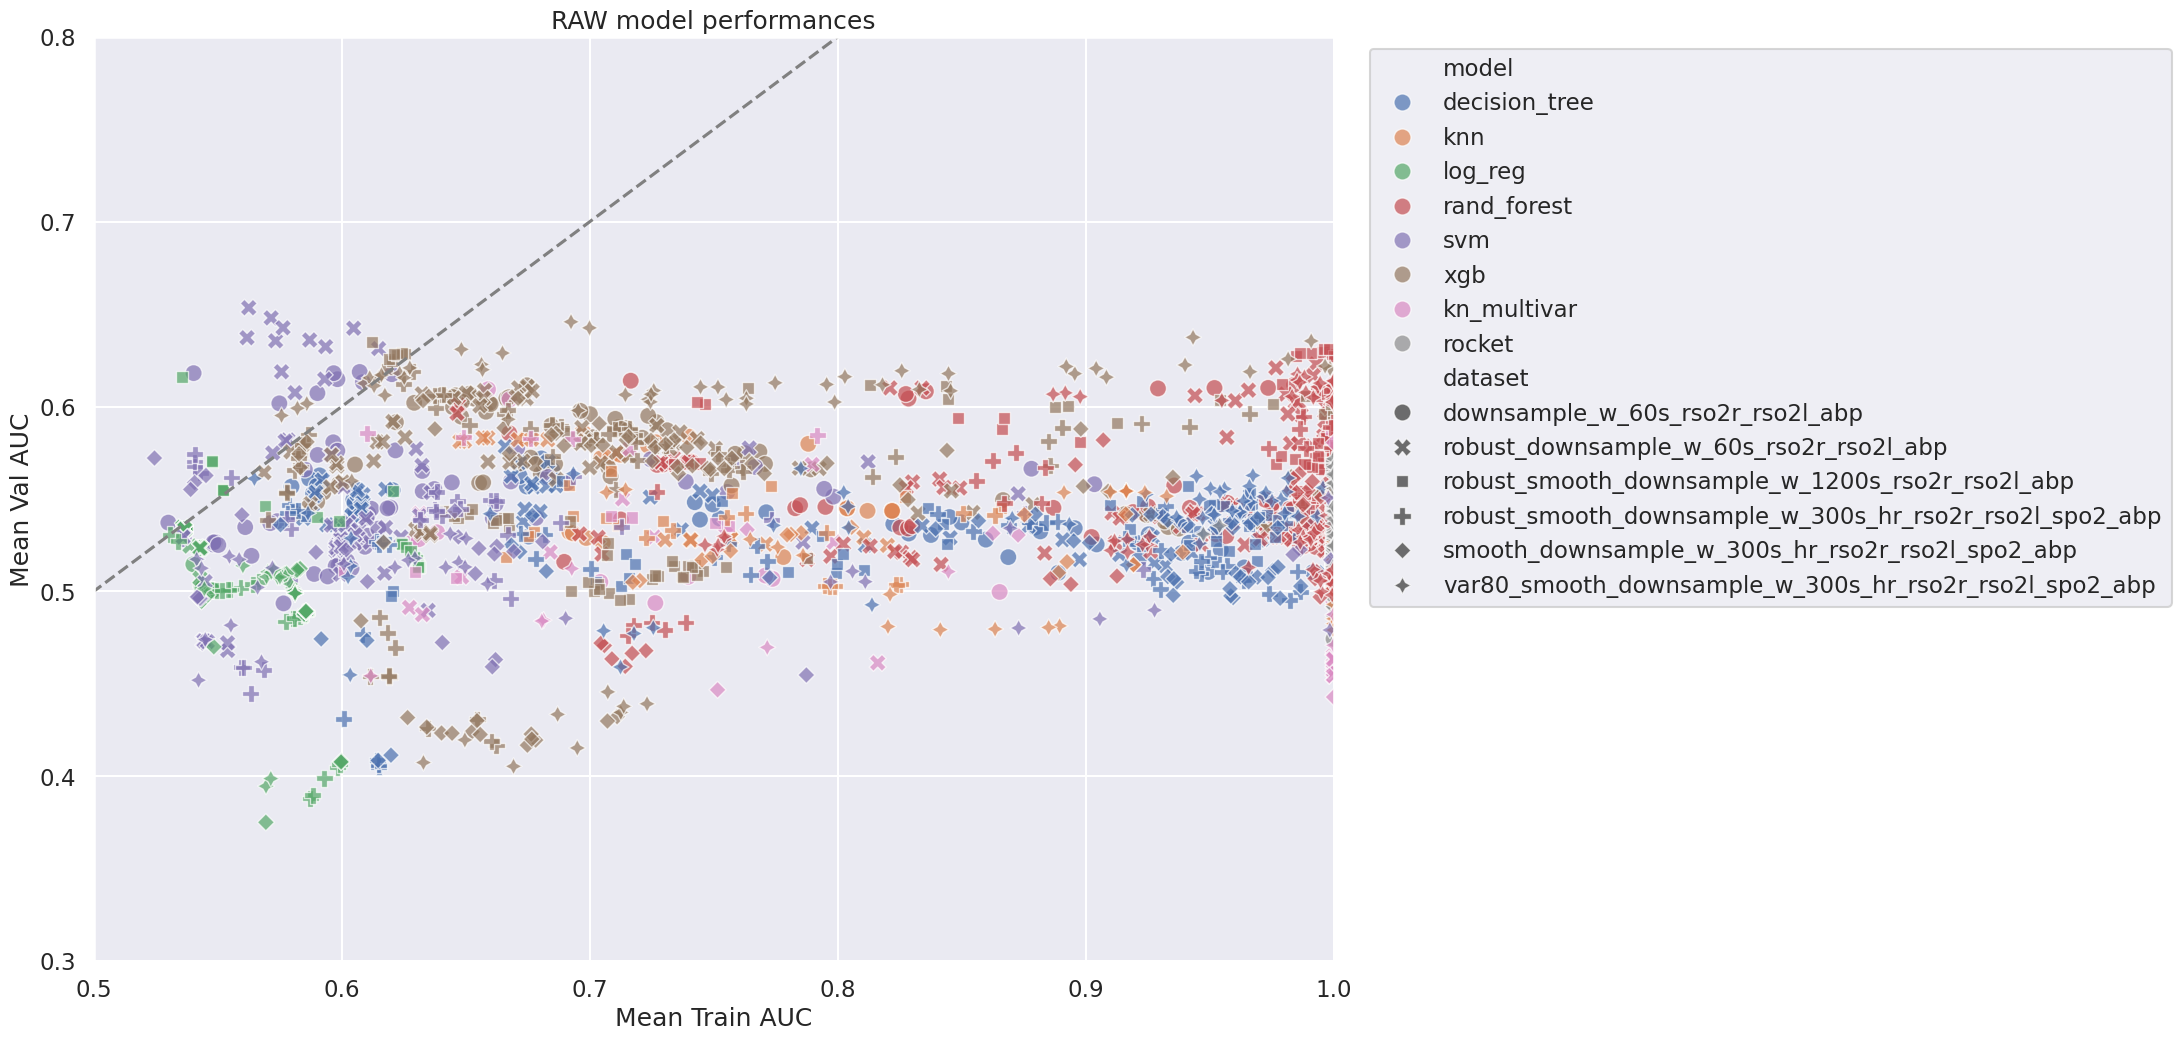

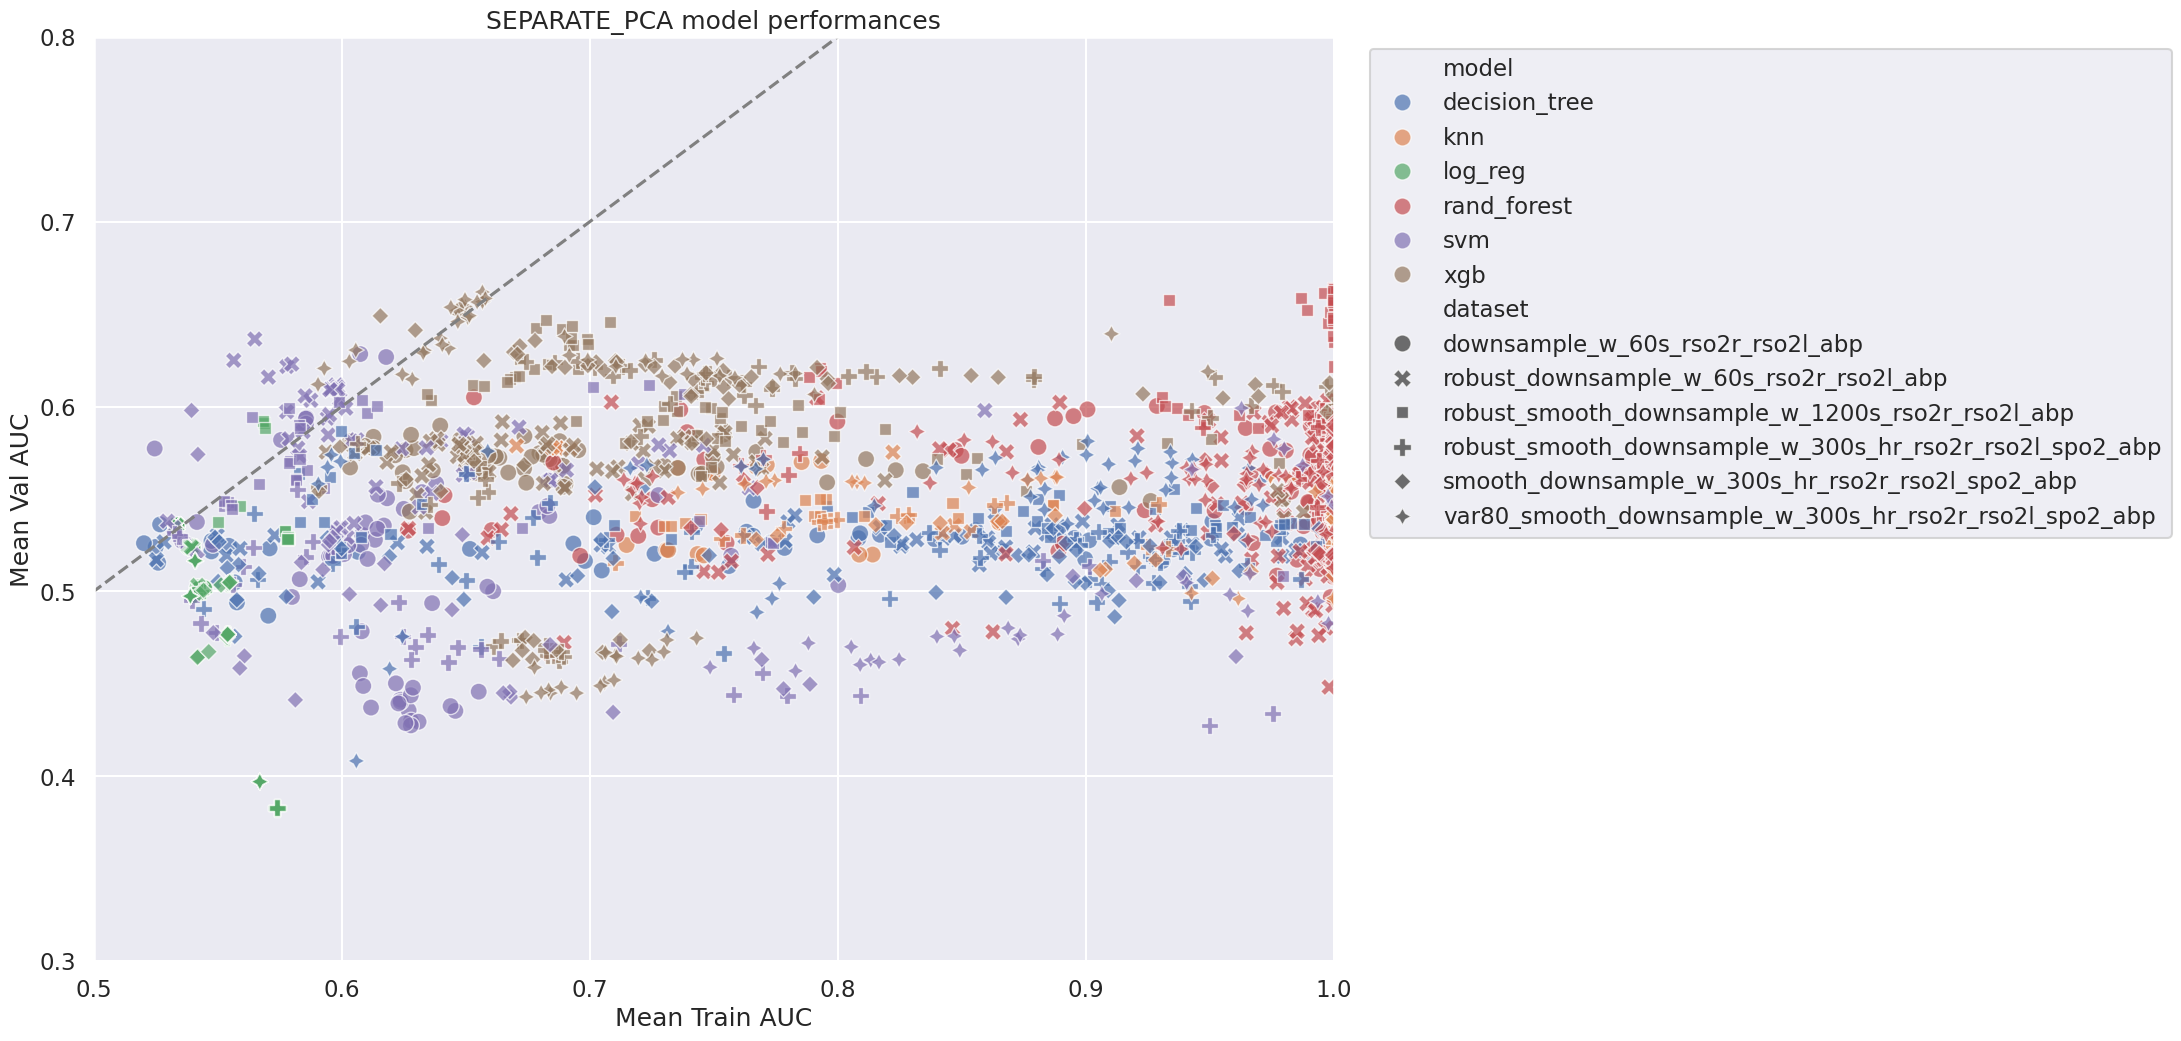

In [35]:
# plot all model performances on scatter plot
plt.figure(figsize=(10, 5))
for embedding in large_result_df.datamode.unique():
    plt.figure(figsize=(16, 12))
    d = large_result_df[large_result_df.datamode == embedding]
    g = sns.scatterplot(
        data=d,
        x = "mean_train_auc",
        y = "mean_val_auc",
        hue="model",
        style="dataset",
        s=150,
        alpha=0.7
    )
    # add y=x line
    plt.plot([0, 1], [0, 1], ls='--', c='gray')
    g.set_title(f"{embedding.upper()} model performances")
    g.set_xlabel("Mean Train AUC")
    g.set_ylabel("Mean Val AUC")
    g.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    g.set_ylim(0.3, 0.8)
    g.set_xlim(0.5, 1.0)
    
    img_name = f"{embedding}_all_models_performance.png"
    plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')


<Figure size 1000x500 with 0 Axes>

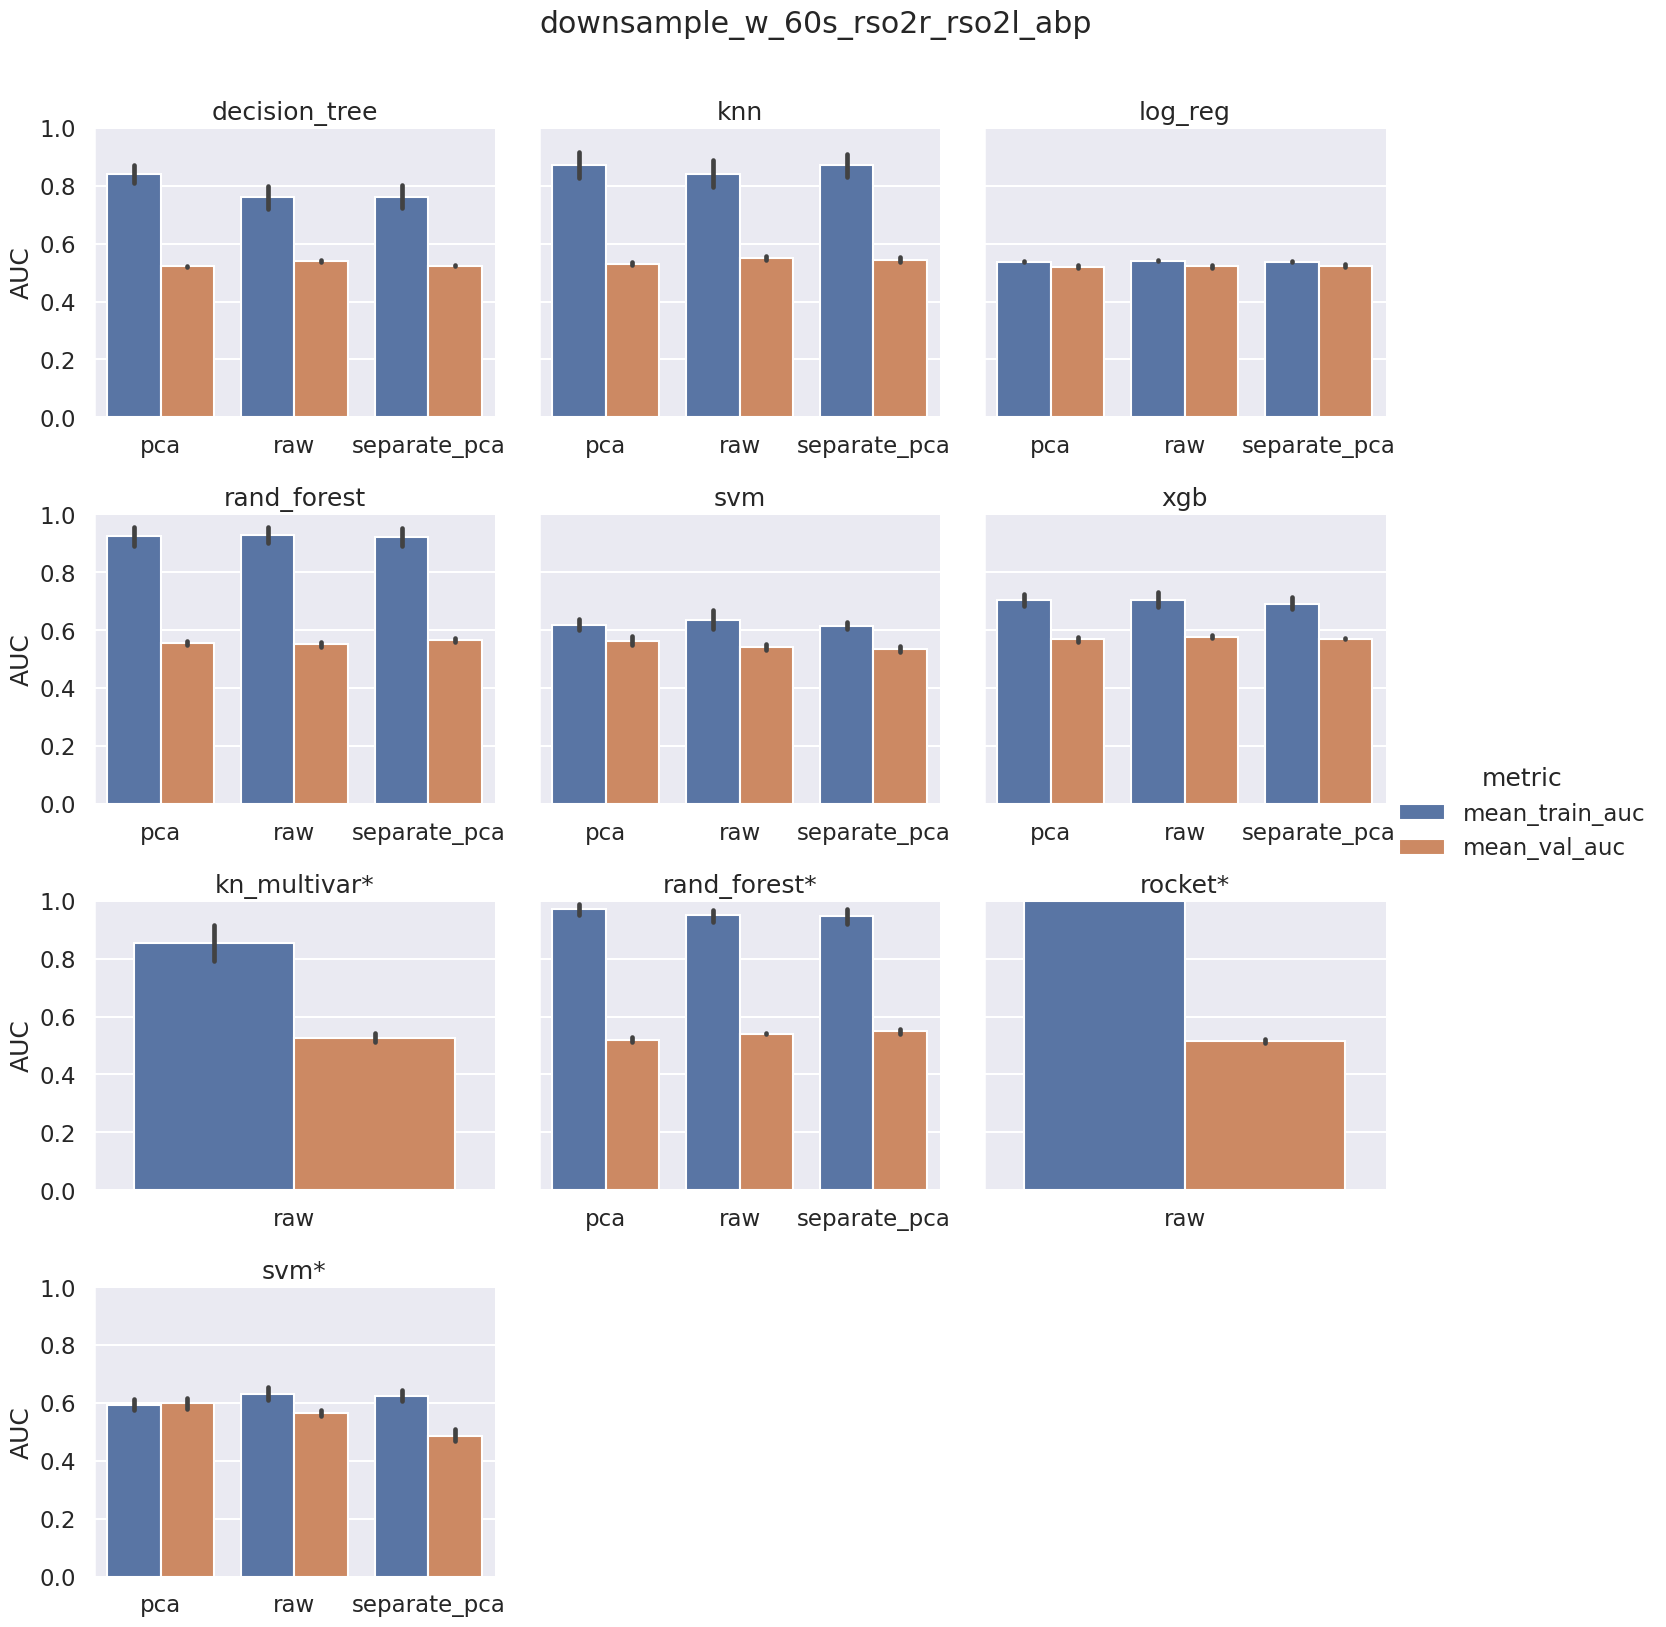

<Figure size 1000x500 with 0 Axes>

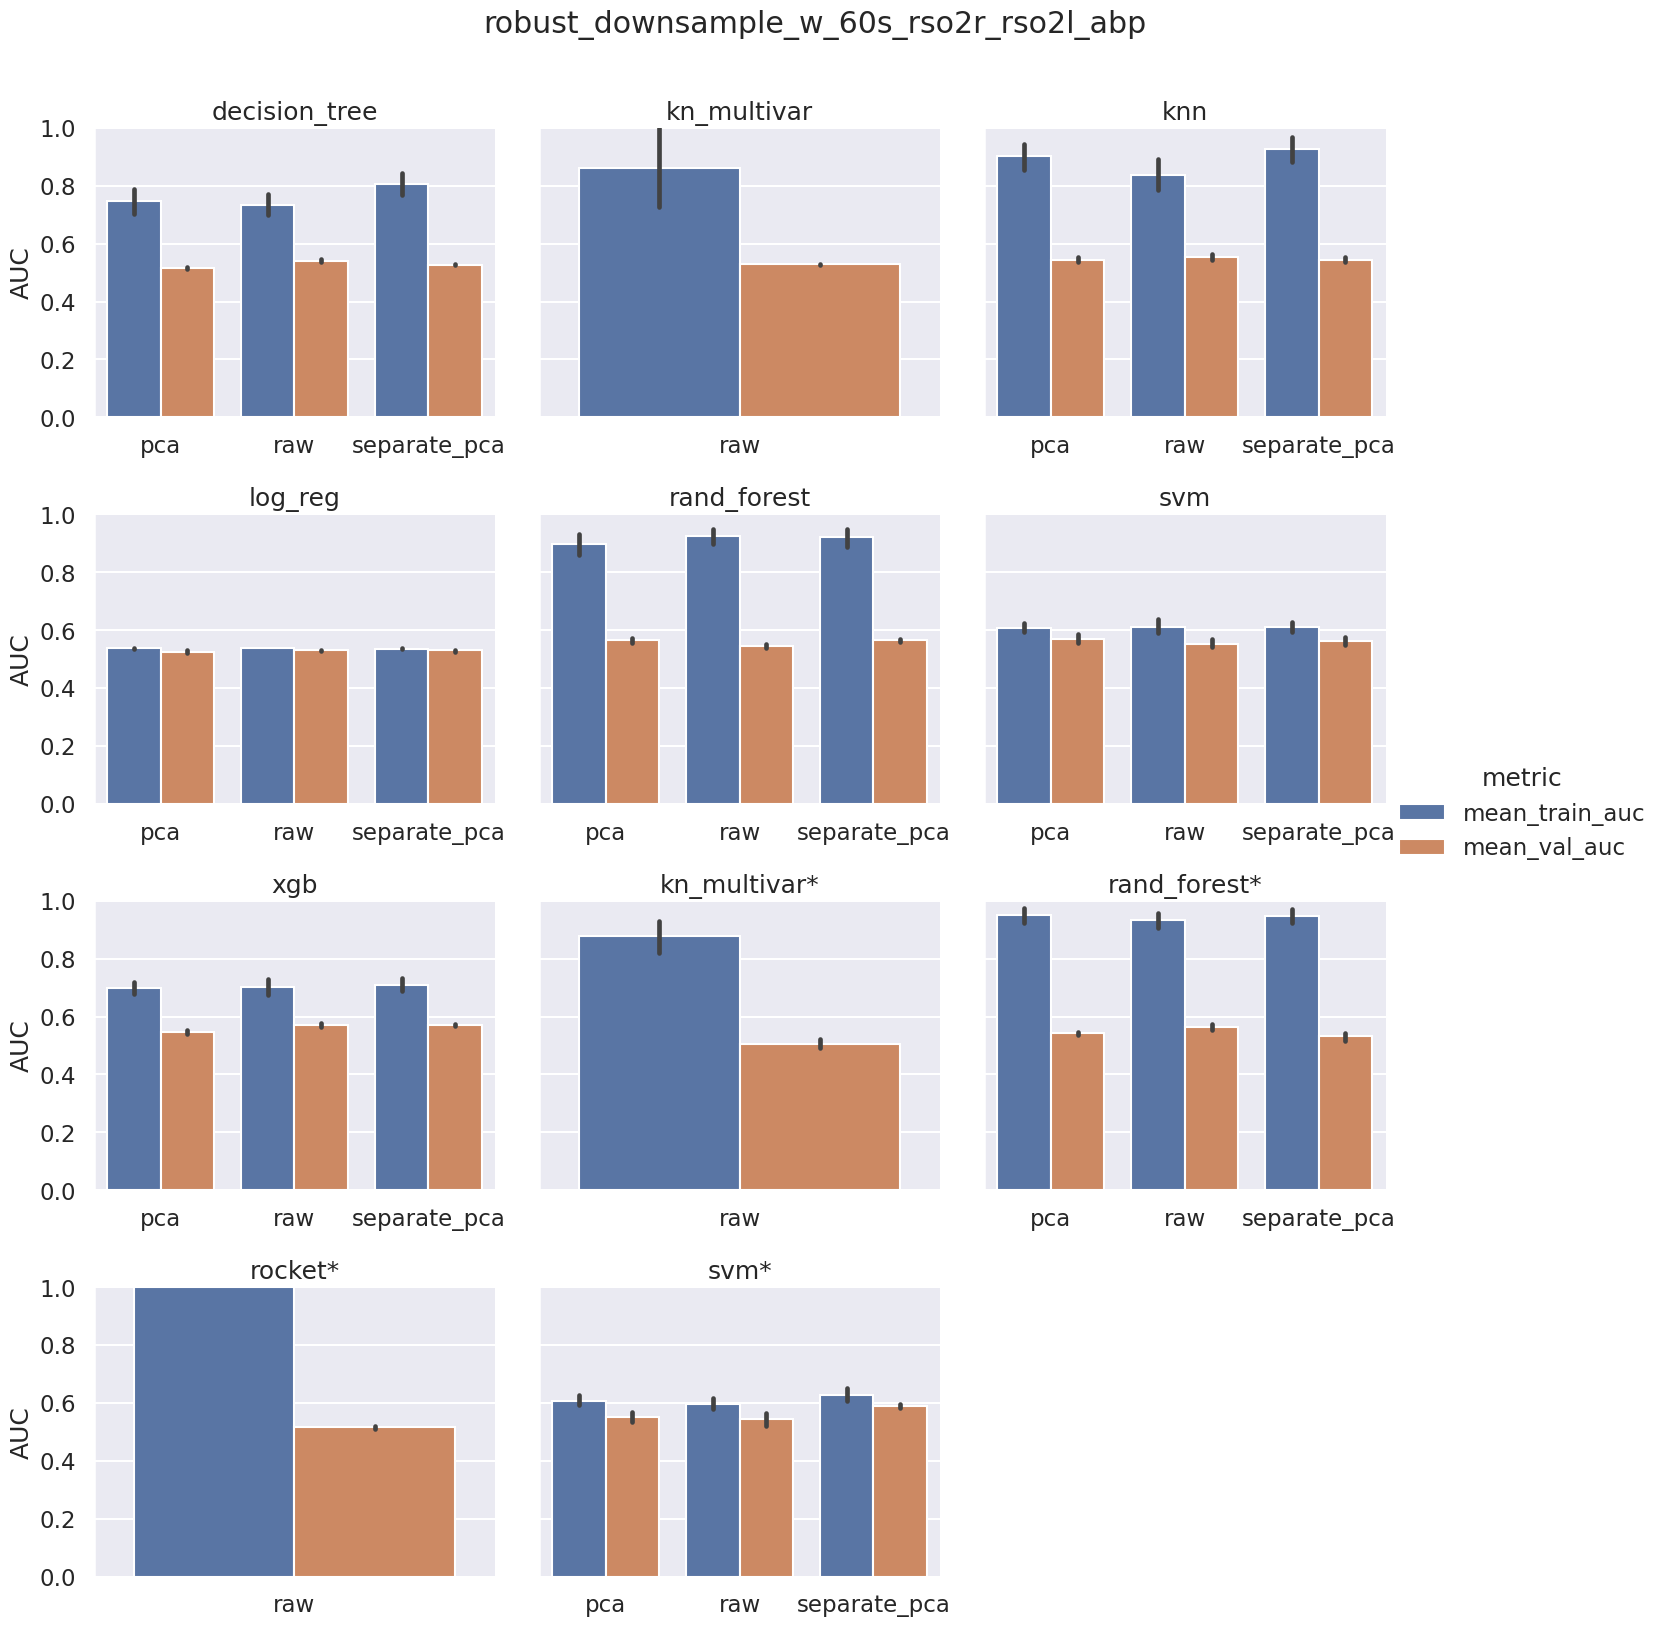

<Figure size 1000x500 with 0 Axes>

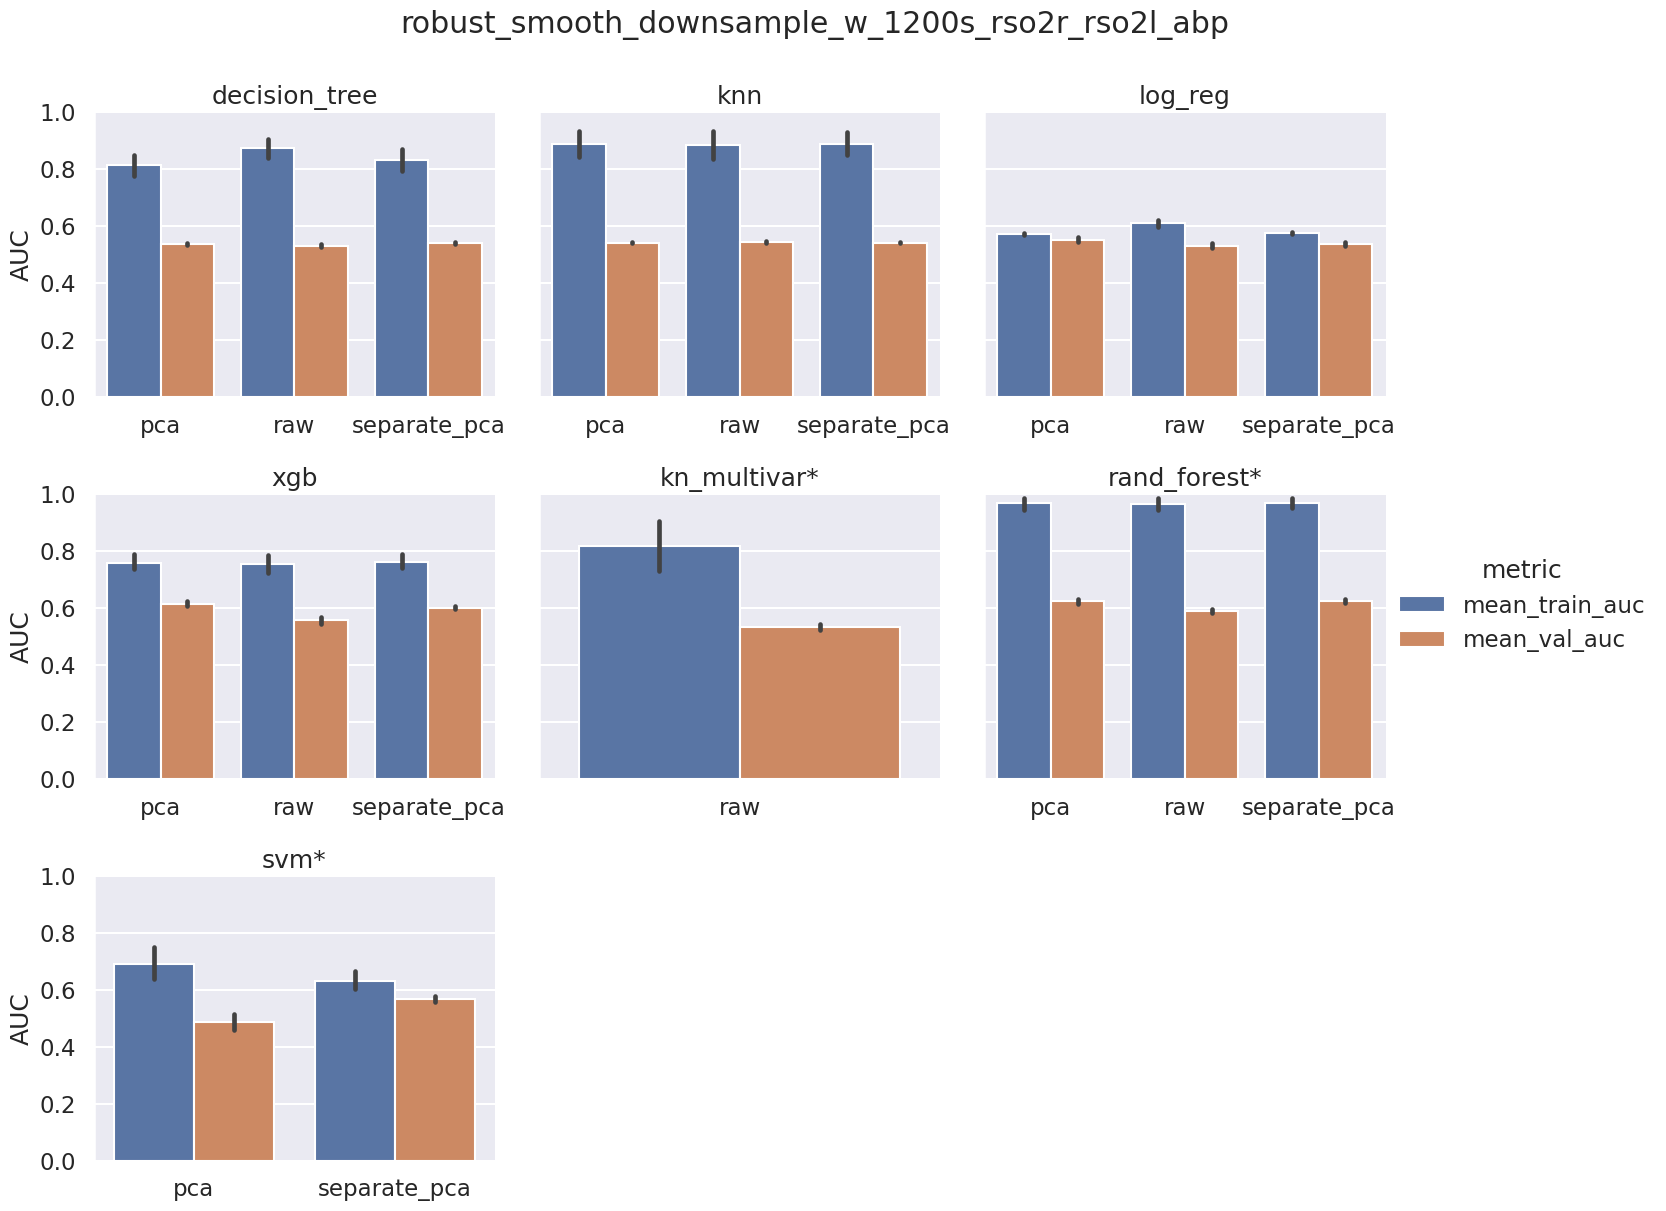

<Figure size 1000x500 with 0 Axes>

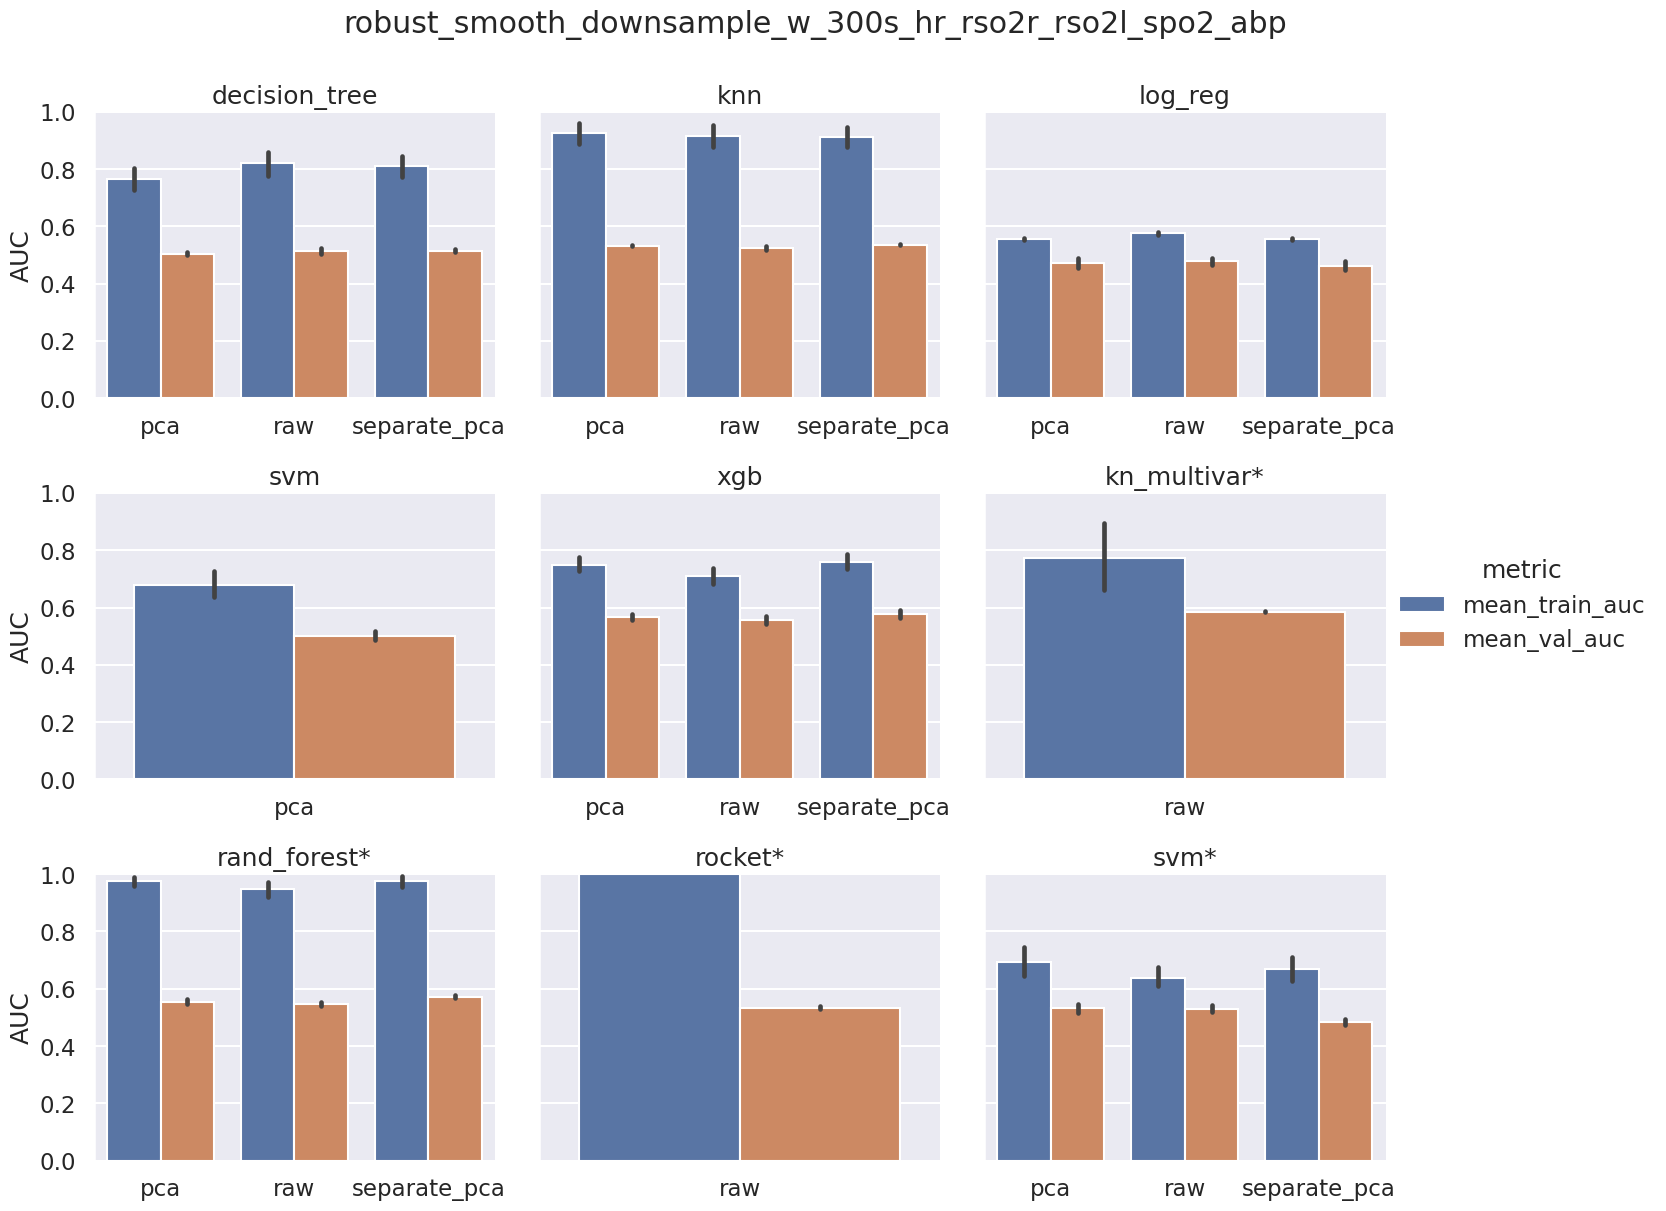

<Figure size 1000x500 with 0 Axes>

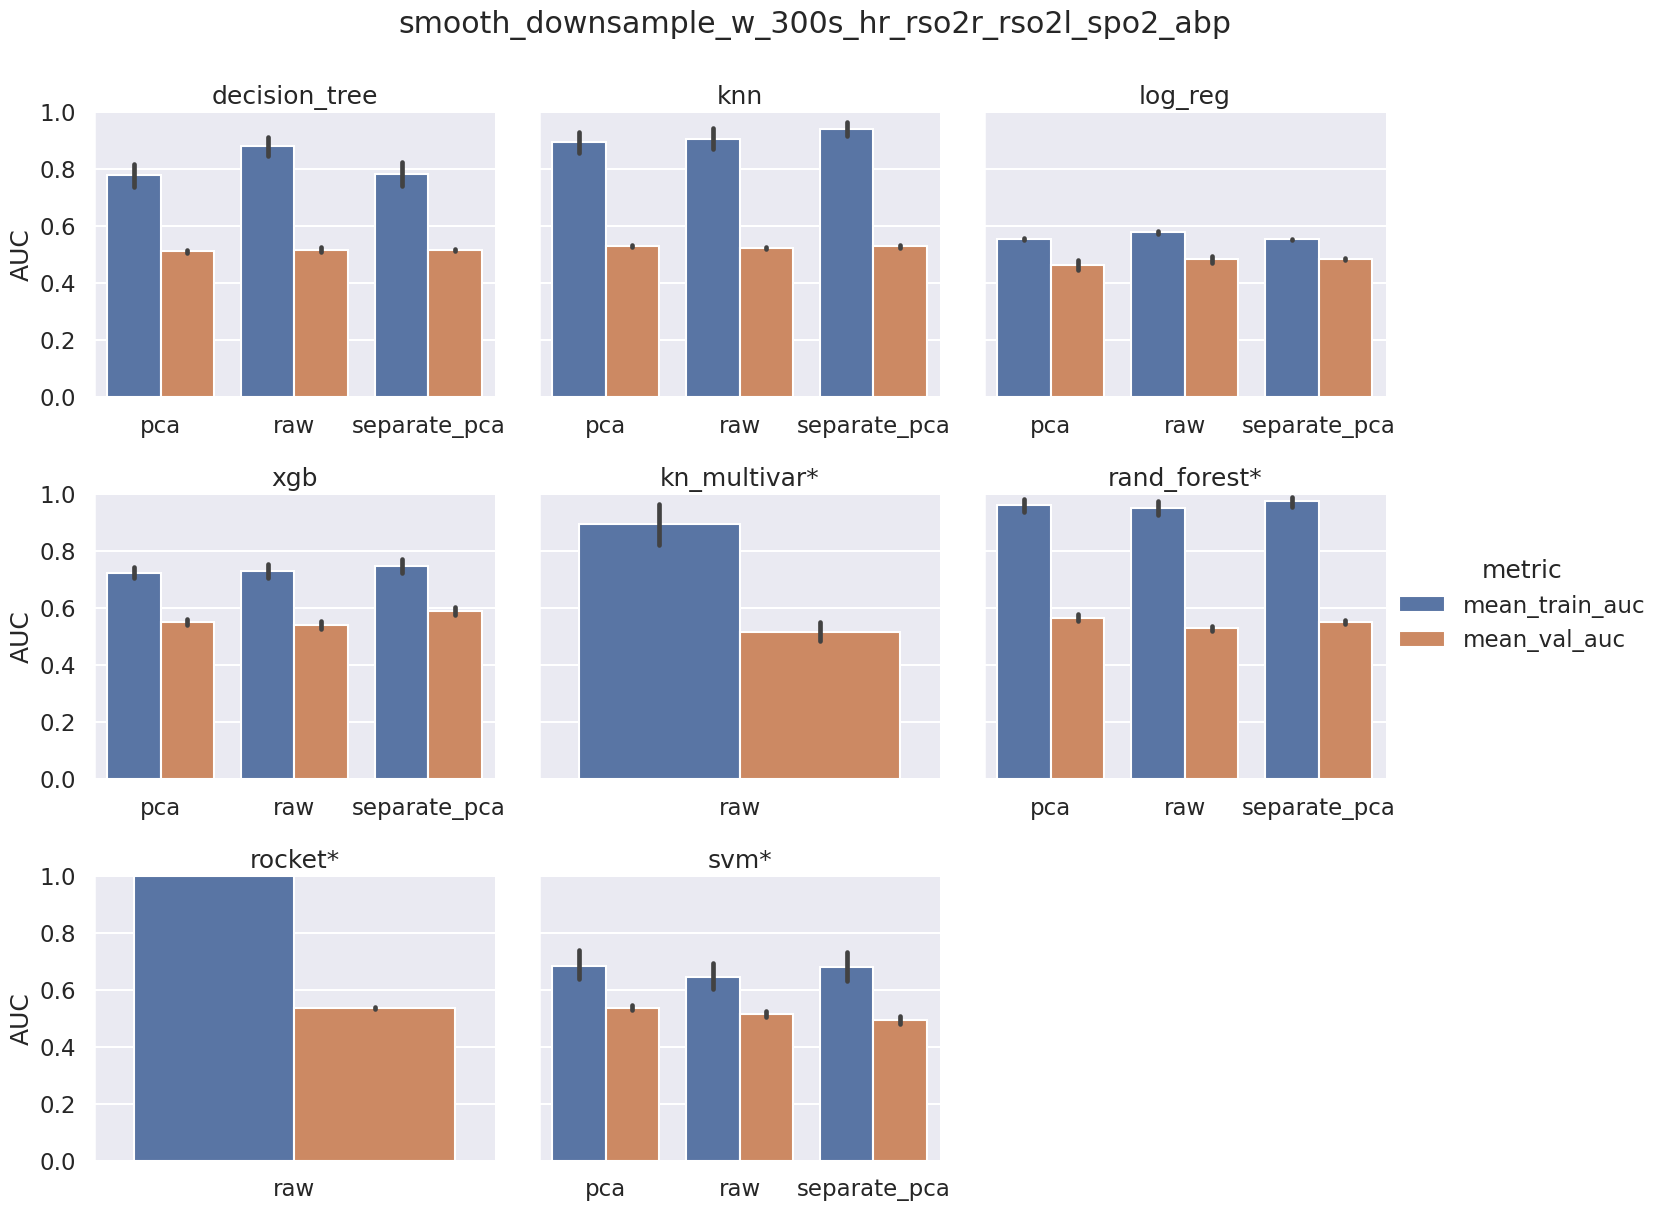

<Figure size 1000x500 with 0 Axes>

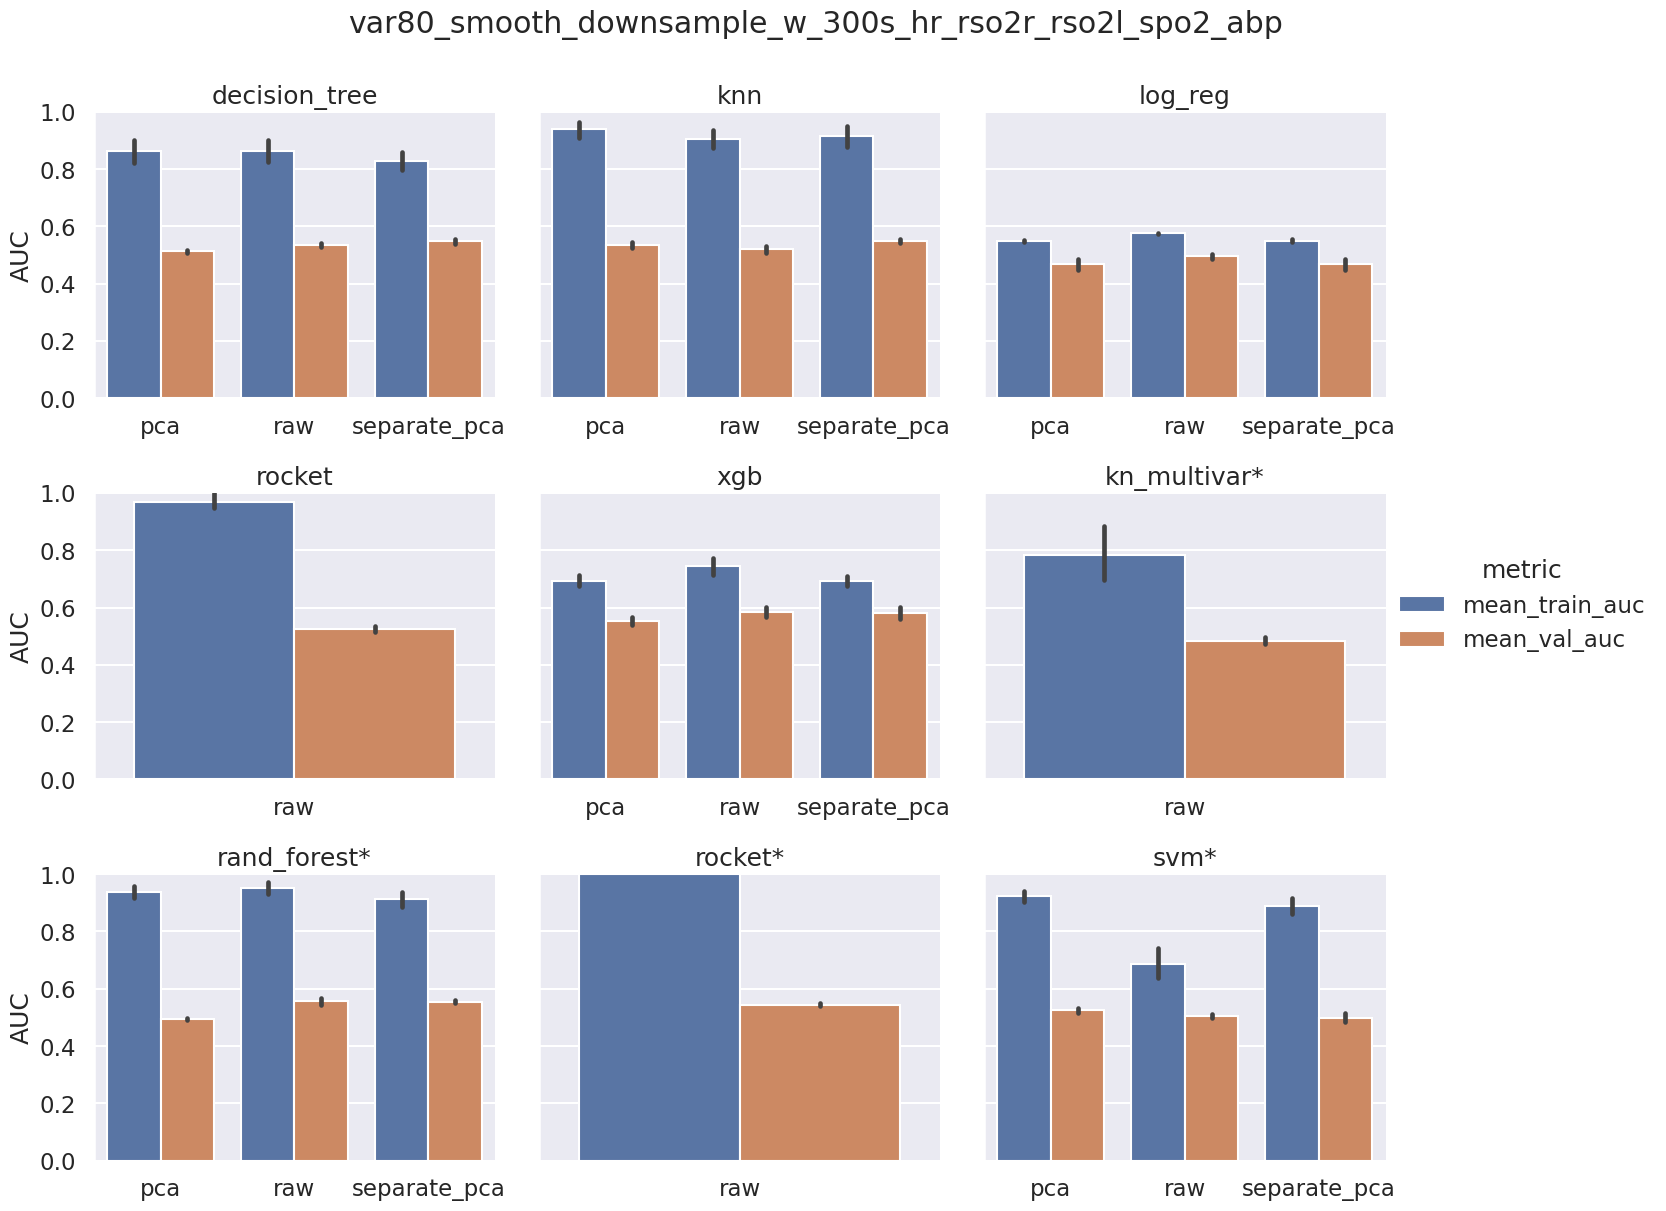

In [36]:
# plot
for ds in long_df.dataset.unique():
    plot_df = long_df[(long_df.dataset == ds)].copy()
    plot_df["model"] = np.where(plot_df["debug"], plot_df["model"] + "*",plot_df["model"])
    # plot grouped barchart of train_auc and val_auc with model on x axis
    if plot_df.empty:
        continue

    plt.figure(figsize=(10, 5))
    g = sns.catplot(
        data=plot_df,
        x="datamode",
        y="auc",
        hue="metric",
        col="model",
        kind="bar",
        dodge=True,
        height=4,
        aspect=1.2,
        col_wrap = 3,
        sharex=False,
    )
    g.set_titles("{col_name}")
    # g.set_xticklabels(rotation=30)
    g.set_axis_labels("", "AUC")
    g.set(ylim=(0, 1))
    # g.legend.set_loc("upper right")

    
    plt.suptitle(f"{ds}", y=1.04)
    # plt.tight_layout()
    # plt.legend(loc=(1,1))
    img_name = f"{ds}.png"
    plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
    plt.show()


In [37]:
plt.close()

In [38]:
# display top 5 per group
for s in long_df.metric.unique():
    print(f"Top 5 for {s}:")
    print(long_df[long_df.metric == s].sort_values(by="auc", ascending=False).head(5))

Top 5 for mean_train_auc:
                                                dataset  debug   model  \
4424   smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp   True     svm   
4576  var80_smooth_downsample_w_300s_hr_rso2r_rso2l_...  False     knn   
930                    downsample_w_60s_rso2r_rso2l_abp   True  rocket   
931                    downsample_w_60s_rso2r_rso2l_abp   True  rocket   
932                    downsample_w_60s_rso2r_rso2l_abp   True  rocket   

          datamode          metric        auc  
4424  separate_pca  mean_train_auc      1.000  
4576           pca  mean_train_auc      1.000  
930            raw  mean_train_auc      1.000  
931            raw  mean_train_auc      1.000  
932            raw  mean_train_auc      1.000  
Top 5 for mean_val_auc:
                                               dataset  debug        model  \
7685  robust_smooth_downsample_w_1200s_rso2r_rso2l_abp  False          xgb   
7830  robust_smooth_downsample_w_1200s_rso2r_rso2l_abp   True

In [47]:
# determine which models and datasets have highest performance
groups = large_result_df.groupby(['dataset'])
print(groups['mean_val_auc'].max().sort_values(ascending=False)[:50])
print(groups['mean_val_auc'].mean().sort_values(ascending=False)[:50])

dataset
robust_smooth_downsample_w_1200s_rso2r_rso2l_abp               0.684
var80_smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp         0.662
downsample_w_60s_rso2r_rso2l_abp                               0.659
robust_downsample_w_60s_rso2r_rso2l_abp                        0.654
smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp               0.649
robust_smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp        0.625
Name: mean_val_auc, dtype: float64
dataset
robust_smooth_downsample_w_1200s_rso2r_rso2l_abp               0.565
robust_downsample_w_60s_rso2r_rso2l_abp                        0.548
downsample_w_60s_rso2r_rso2l_abp                               0.545
var80_smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp         0.534
robust_smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp        0.532
smooth_downsample_w_300s_hr_rso2r_rso2l_spo2_abp               0.529
Name: mean_val_auc, dtype: float64


### Models

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
# loop through training dirs, pick out best model
def model_pkl_iter(dataset_names, run_name):
    for ds in dataset_names:
        ds_path = os.path.join(train_dir, ds)
        for model_dir in os.listdir(ds_path):
            if run_name in model_dir:
                # grab model paths
                md_path = os.path.join(ds_path, model_dir)
                for m in os.listdir(md_path):
                    model_path = os.path.join(md_path, m)
                    if m.endswith(".pkl"):
                        yield model_path, "debug" in model_dir

In [ ]:
# confusion matrices for best models TBD
for m, d in model_pkl_iter(dataset_names, run_name):
    print(m, d)
    # load  dataset and evaluate??



/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/decision_tree_pca.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/decision_tree_raw.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/decision_tree_separate_pca.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/knn_pca.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/knn_raw.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/knn_separate_pca.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data/training/downsample_w_60s_rso2r_rso2l_abp/models_current/log_reg_pca.pkl False
/home/mr2238/project_pi_np442/mr2238/accelerate/data